In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("clean_data.csv")

print("Размер исходного датасета:", df.shape)
display(df.head(5))
display(df.info())

Размер исходного датасета: (188007, 1308)


,Unnamed: 0,radiant_gold_adv_0,radiant_gold_adv_1,radiant_gold_adv_2,radiant_gold_adv_3,radiant_gold_adv_4,radiant_gold_adv_5,radiant_gold_adv_6,radiant_gold_adv_7,radiant_gold_adv_8,...,radiant_xp_adv_117.1,radiant_xp_adv_118.1,radiant_xp_adv_119.1,radiant_xp_adv_120.1,radiant_xp_adv_121.1,radiant_xp_adv_122.1,radiant_xp_adv_123.1,radiant_xp_adv_124.1,duration_in_min,first_blood_time_in_min
0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.716667,0.000000
1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.983333,0.000000
2,155,596.0,235.0,-125.0,536.0,923.0,1193.0,1636.0,1683.0,2422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.483333,0.000000
3,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.116667,1.783333
4,157,578.0,470.0,258.0,-161.0,-801.0,-2728.0,-2994.0,-3945.0,-4768.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.800000,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188007 entries, 0 to 188006
Columns: 1308 entries, Unnamed: 0 to first_blood_time_in_min
dtypes: bool(50), float64(1018), int64(208), object(32)
memory usage: 1.8+ GB


None

In [3]:
# Будем прогнозировать на основе драфтов, выбранных героев и игроков
# Задаем список подстрок, которые должны присутствовать в именах столбцов
patterns = [
    "draft",
    "account_id_",
    "party_id",
    "hero_variant",
    "name_",
    "isRadiant_",
    "rank_tier_",
    "game_mode",
    "lobby_type",
    "start_time",
    "version",
    "series_type",
    "patch",
    "region",
    "radiant_win"
]

# Фильтруем столбцы: оставляем только те, в имени которых встречается хотя бы одна из подстрок
cols_to_keep = [col for col in df.columns if any(pattern in col for pattern in patterns)]

# Создаем новый DataFrame только с выбранными столбцами
df_model = df[cols_to_keep].copy()

print("Размер датасета после фильтрации:", df_model.shape)

Размер датасета после фильтрации: (188007, 248)


In [4]:
# Определяем X и y
X = df_model.drop(columns=['radiant_win'])
y = df_model['radiant_win']

print("Размер X:", X.shape)
print("Размер y:", y.shape)

Размер X: (188007, 247)
Размер y: (188007,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (150405, 247)
X_test: (37602, 247)
y_train: (150405,)
y_test: (37602,)


In [6]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [7]:
from sklearn.compose import ColumnTransformer

# Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем оба пайплайна в один ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=10000),
    'DummyClassifier': DummyClassifier(strategy='most_frequent')
}


In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Обучает модель, предсказывает на тестовой выборке, выводит accuracy, confusion matrix, classification report.
    Также строит ROC-кривую (если применимо).
    """
    # Обучение модели
    model.fit(X_train, y_train)
    # Предсказание
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("\n=====================================")
    print(f"[MODEL] {model.__class__.__name__}")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model.__class__.__name__}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    elif hasattr(model, "decision_function"):
        # Для моделей, где используется decision_function (например, LinearSVC)
        y_scores = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model.__class__.__name__}")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    return acc


-----------------------------
Обучение модели: LogisticRegression
[TEST] Accuracy: 0.5317

[MODEL] Pipeline
Accuracy: 0.5317

Classification Report:
              precision    recall  f1-score   support

       False       0.53      0.53      0.53     18639
        True       0.54      0.54      0.54     18963

    accuracy                           0.53     37602
   macro avg       0.53      0.53      0.53     37602
weighted avg       0.53      0.53      0.53     37602



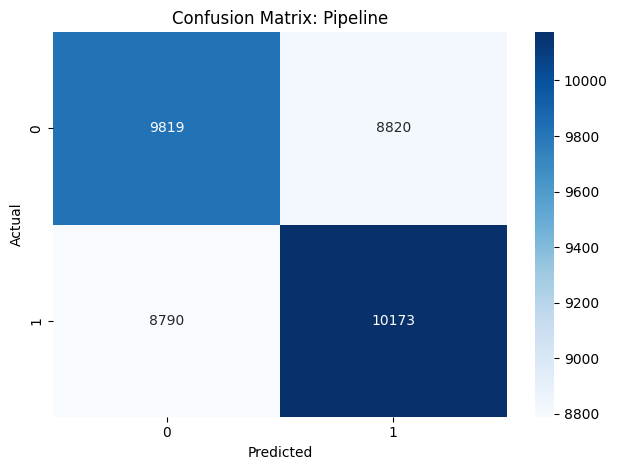

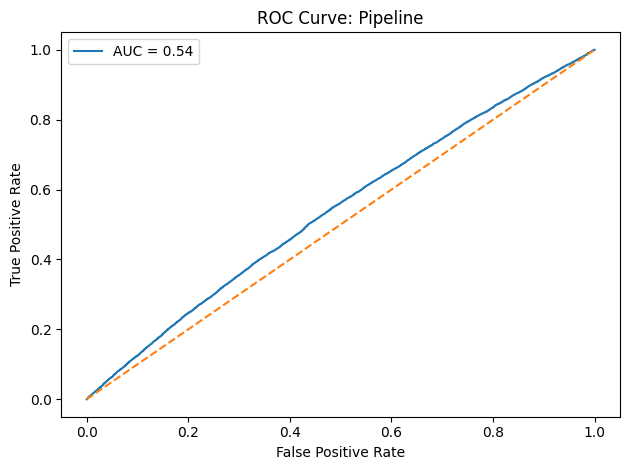


-----------------------------
Обучение модели: LinearSVC


In [ ]:
# Обучение и оценка моделей без гиперпараметров
results = {}
for model_name, model_instance in models.items():
    print("\n-----------------------------")
    print(f"Обучение модели: {model_name}")
    # Создаем пайплайн с предобработкой и моделью
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_instance)
    ])
    
    
    # Обучаем на всей обучающей выборке и оцениваем на тестовой
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"[TEST] Accuracy: {test_acc:.4f}")
    results[model_name] = test_acc
    
    # Оценка модели (функция выводит метрики и сохраняет графики)
    _ = evaluate_model(pipeline, X_train, X_test, y_train, y_test)
    
    time.sleep(1)

In [ ]:
# Сравнение результатов моделей
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

# Построим bar chart для сравнения accuracy
plt.figure()
model_names = list(results.keys())
acc_values = list(results.values())
sns.barplot(x=model_names, y=acc_values, palette='viridis')
plt.xlabel("Модель")
plt.ylabel("Test Accuracy")
plt.title("Сравнение тестовых accuracy для моделей")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()